# Cython Analysis

The dual_autodiff package has a Cythonized version called dual_autodiff_x. Let's analyse the performances for both of the packages.

In [1]:
#import the required packages
import numpy as np
import time
import matplotlib.pyplot as plt
from typing import List, Tuple
from dual_autodiff import dual
from dual_autodiff_x import dual as dual_x
from dual_autodiff.tools import add_function
from dual_autodiff_x.tools import add_function as add_function_x

First, let's verify that the Cython and Python versions give us the same results.

In [2]:
#Define the function and the partial derivatives with the same example in the demo
def fmv (x, y):
    return y**2 * np.sinh(3 * x + 2) + 2 * y + x

def fmv_x(x, y):
    return 3 * y**2 * np.cosh(3 * x + 2) + 1

def fmv_y (x, y):
    return 2 * y * np.sinh(3 * x + 2) + 2

In [3]:
#define dual numbers x and y using both packages

py_x_dual = dual.Dual(1, {'x': 1, 'y': 0})
cy_x_dual = dual_x.Dual(1, {'x': 1, 'y': 0})
py_y_dual = dual.Dual(2, {'x': 0, 'y': 1})
cy_y_dual = dual_x.Dual(2, {'x': 0, 'y': 1})

print(f"Python partial derivative wrt x: f_x(x = 1, y = 2) = {fmv(py_x_dual, py_y_dual).dual['x']}")
print(f"Cython partial derivative wrt x: f_x(x = 1, y = 2) = {fmv(cy_x_dual, cy_y_dual).dual['x']}")
print(f"Python partial derivative wrt y: f_y(x = 1, y = 2) = {fmv(py_x_dual, py_y_dual).dual['y']}")
print(f"Cython partial derivative wrt y: f_y(x = 1, y = 2) = {fmv(cy_x_dual, cy_y_dual).dual['y']}")

Python partial derivative wrt x: f_x(x = 1, y = 2) = 891.5193822974542
Cython partial derivative wrt x: f_x(x = 1, y = 2) = 891.5193822974542
Python partial derivative wrt y: f_y(x = 1, y = 2) = 298.812842311155
Cython partial derivative wrt y: f_y(x = 1, y = 2) = 298.812842311155


They give the exact same results.

Test the speeds of the pure Python and Cython version of the package for different operations.

In [16]:
#Define the sigmoid function - this will be used as the custom function
def sigmoid(x):
    """Sigmoid function implementation"""
    return 1 / (np.exp(-x)+1)

def sigmoid_derivative(x):
    """Derivative of sigmoid function"""
    s = sigmoid(x)
    return s * (1 - s)

def benchmark_operation(operation: str, sizes: List[int], 
                       py_dual, cy_dual, num_trials: int = 5) -> Tuple[List[float], List[float]]:
    """
    Benchmark a specific operation for both Python and Cython implementations.
    Includes testing of
    - addition
    - multiplication
    - division
    - powers
    - sin
    - cosh
    - exp
    - sigmoid (custom function)
    """
    py_times = []
    cy_times = []
    
    for size in sizes:
        py_total = 0
        cy_total = 0
        
        for _ in range(num_trials):
            x_vals = np.random.rand(size)
            
            # Python version timing
            py_start = time.time()
            for i in range(size): #for different numbers of operations
                x = py_dual(x_vals[i], {'x': 1.0})
                if operation in ['add', 'mul', 'div', 'pow']:
                    y = py_dual(x_vals[i], {'y': 1.0}) #if involving another dual number - binary operation
                    if operation == 'add':
                        result = x + y
                    elif operation == 'mul':
                        result = x * y
                    elif operation == 'div':
                        result = x / y
                    elif operation == 'pow':
                        result = x ** y
                #if does not involve another dual number - unary operation
                elif operation == 'sin':
                    result = np.sin(x)
                elif operation == 'cosh':
                    result = np.cosh(x)
                elif operation == 'exp':
                    result = np.exp(x)
                elif operation == 'sigmoid':
                    result = sigmoid(x)
            py_total += time.time() - py_start 
            
            # Cython version timing
            cy_start = time.time()
            for i in range(size):
                x = cy_dual(x_vals[i], {'x': 1.0})
                if operation in ['add', 'mul', 'div', 'pow']:
                    y = cy_dual(x_vals[i], {'y': 1.0})
                    if operation == 'add':
                        result = x + y
                    elif operation == 'mul':
                        result = x * y
                    elif operation == 'div':
                        result = x / y
                    elif operation == 'pow':
                        result = x ** y
                elif operation == 'sin':
                    result = np.sin(x)
                elif operation == 'cosh':
                    result = np.cosh(x)
                elif operation == 'exp':
                    result = np.exp(x)
                elif operation == 'sigmoid':
                    result = sigmoid(x)
            cy_total += time.time() - cy_start
        
        #save the times
        py_times.append(py_total / num_trials)
        cy_times.append(cy_total / num_trials)
    
    return py_times, cy_times

def run_benchmarks(py_dual, cy_dual):
    """Run the benchmarks and plot"""

    # Add the sigmoid function to both implementations
    add_function('sigmoid', sigmoid, sigmoid_derivative)
    add_function_x('sigmoid', sigmoid, sigmoid_derivative)
    
    operations = ['add', 'mul', 'div', 'pow', 'sin', 'cosh','exp', 'sigmoid']
    sizes = [100, 1000, 5000, 10000, 50000]
    
    plt.figure(figsize=(20, 12))
    
    for idx, op in enumerate(operations, 1):
        plt.subplot(2, 4, idx)
        py_times, cy_times = benchmark_operation(op, sizes, py_dual, cy_dual)
        
        # Calculate speedup
        speedups = [py/cy for py, cy in zip(py_times, cy_times)]
        
        # Plot timing comparison
        plt.plot(sizes, py_times, 'o-', label='Python', color='blue')
        plt.plot(sizes, cy_times, 'o-', label='Cython', color='red')
        
        plt.title(f'{op.capitalize()} Operation\nMax Speedup: {max(speedups):.2f}x')
        plt.xlabel('Input Size')
        plt.ylabel('Time (seconds)')
        plt.grid(True)
        plt.legend()
        
        # Log scale 
        
        #plt.yscale('log')
        
    plt.tight_layout()
    return plt

#Analyse how much memory it takes to store a dual number for python and cython version
def analyse_memory_usage(py_dual, cy_dual):
    """Analyse memory usage"""
    import sys
    
    #Create random number
    x_val = np.random.rand()
    
    #create dual numbers
    py_dual = py_dual(x_val, {'x': 1.0})
    cy_dual = cy_dual(x_val, {'x': 1.0})
    
    return sys.getsizeof(py_dual), sys.getsizeof(cy_dual) 

Memory usage per object: Python=48 bytes, Cython=56 bytes


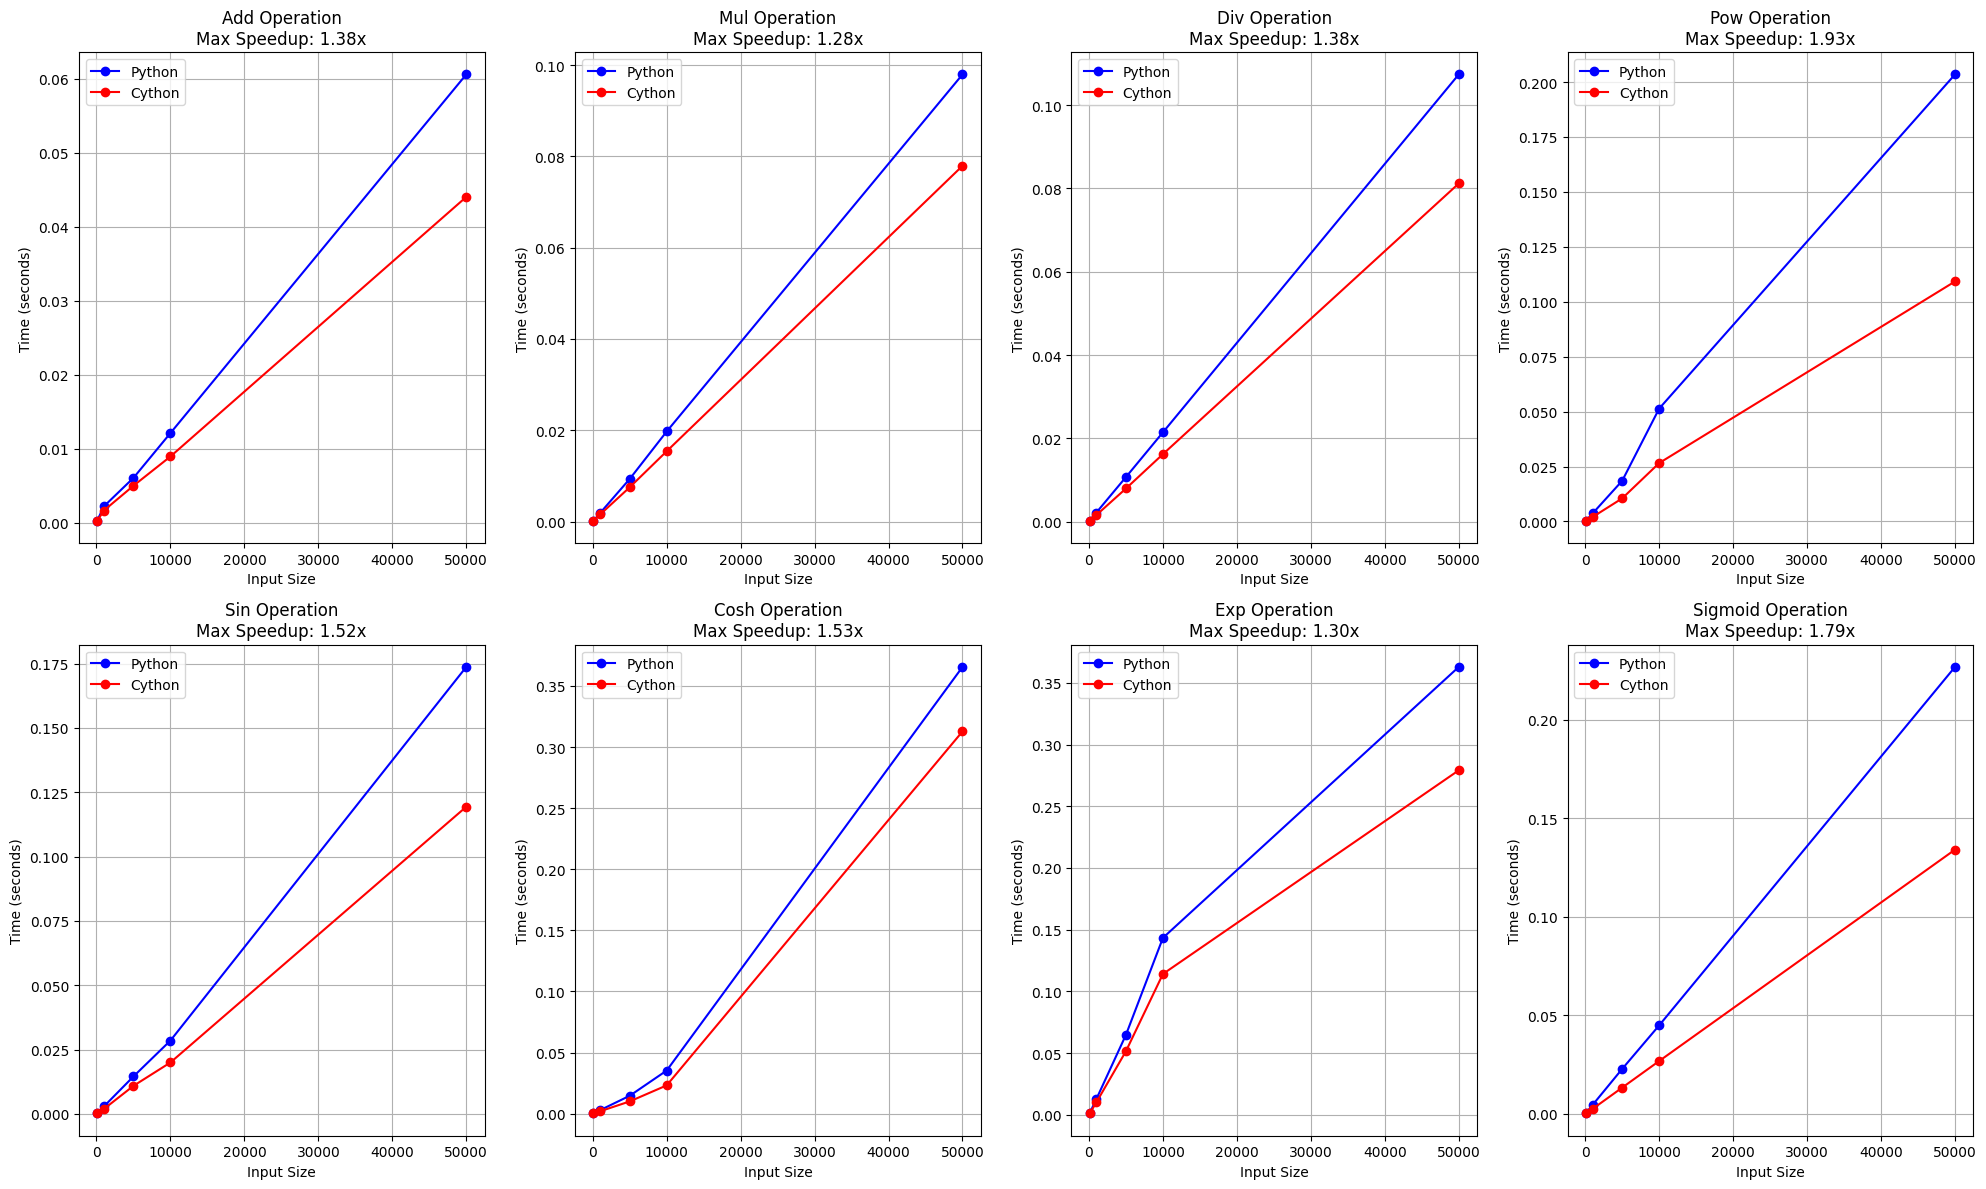

In [18]:
# Run benchmarks
plt = run_benchmarks(dual.Dual, dual_x.Dual)
plt.savefig('dual_benchmarks.png')

# Check memory usage
py_size, cy_size = analyse_memory_usage(dual.Dual, dual_x.Dual)
print(f"Memory usage per object: Python={py_size} bytes, Cython={cy_size} bytes")

We can see that the Cython package is fast than the Python package for all of these operations.\
It takes more memory, however, to store a dual number using the Cython package as opposed to the Python package.

Now, let's analyse the speeds for partial differentiation with the same example as in the demo notebook.

In [14]:
def benchmark_partial_derivatives(sizes, num_trials=5):
    """
    Benchmark partial derivative computation for both implementations
    
    Args:
        sizes: List of input sizes to test
        num_trials: Number of trials for each size
    """
    py_times = []
    cy_times = []
    
    def fmv(x, y):
        return y**2 * np.sinh(3 * x + 2) + 2 * y + x
    
    for size in sizes:
        py_total = 0
        cy_total = 0
        
        # Generate random points for testing
        x_vals = np.random.rand(size)
        y_vals = np.random.rand(size)
        
        for _ in range(num_trials):
            # Python version timing
            py_start = time.time()
            for i in range(size):
                x_dual = dual.Dual(x_vals[i], {'x': 1, 'y': 0})
                y_dual = dual.Dual(y_vals[i], {'x': 0, 'y': 1})
                result = fmv(x_dual, y_dual)
                dx = result.dual['x']
                dy = result.dual['y']
            py_total += time.time() - py_start
            
            # Cython version timing
            cy_start = time.time()
            for i in range(size):
                x_dual = dual_x.Dual(x_vals[i], {'x': 1, 'y': 0})
                y_dual = dual_x.Dual(y_vals[i], {'x': 0, 'y': 1})
                result = fmv(x_dual, y_dual)
                dx = result.dual['x']
                dy = result.dual['y']
            cy_total += time.time() - cy_start
            
        py_times.append(py_total / num_trials)
        cy_times.append(cy_total / num_trials)
    
    return py_times, cy_times

def run_partial_derivative_benchmark():
    """Create performance comparison plot"""
    sizes = [100, 500, 1000, 5000, 10000, 50000]
    py_times, cy_times = benchmark_partial_derivatives(sizes)
    
    # Calculate speedup
    speedups = [py/cy for py, cy in zip(py_times, cy_times)]
    
    # Create the plot
    plt.figure(figsize=(12, 6))
    
    # Plot timing comparison
    plt.plot(sizes, py_times, 'o-', label='Python', color='blue', linewidth=2)
    plt.plot(sizes, cy_times, 'o-', label='Cython', color='red', linewidth=2)
    
    # Add labels and title
    plt.title(f'Partial Derivatives Performance Comparison\nMax Speedup: {max(speedups):.2f}x', 
              fontsize=14, pad=20)
    plt.xlabel('Number of Evaluations', fontsize=12)
    plt.ylabel('Time (seconds)', fontsize=12)
    
    # Add grid and legend
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=12)
    
    # Use log scale for both axes
    #plt.xscale('log')
    #plt.yscale('log')

    plt.tight_layout()
    return plt

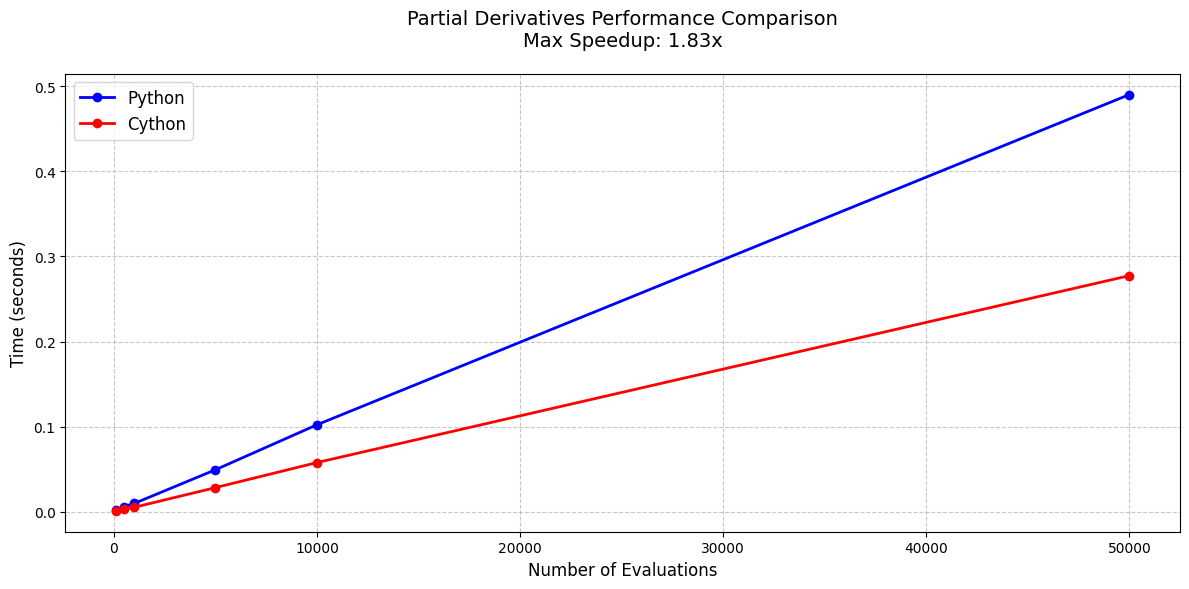

In [15]:
# Create and save the performance comparison plot
plt = run_partial_derivative_benchmark()

plt.savefig('partial_derivatives_benchmark.png', dpi=300, bbox_inches='tight')

The Cython version can be almost doubly as fast as the Python version.